In [ ]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
from census import Census
import gmaps
import matplotlib.ticker as mtick

# Census & gmaps API Keys
from config import (api_key, gkey)
c = Census(api_key, year=2018)

# Configure gmaps
gmaps.configure(api_key=gkey)

In [ ]:
#import Racial Data CSV
csv_path = "Resources/Race Data Entry - CRDT.csv"
race_df = pd.read_csv(csv_path)

In [ ]:
#Remove unneccessary columns and rows from race_df
del race_df['Deaths_Ethnicity_Unknown']
del race_df['Deaths_Ethnicity_NonHispanic']
del race_df['Deaths_Ethnicity_Hispanic']
del race_df['Cases_Ethnicity_Unknown']
del race_df['Cases_Ethnicity_NonHispanic']
del race_df['Cases_Ethnicity_Hispanic']
race_df = race_df.dropna(thresh=9)
race_df = race_df.dropna(subset={'Cases_Total'})
race_df = race_df[(race_df['Date'] == 20200715)]

In [ ]:
#import state abbreviations dictionary
us_state_abbrev = {
    'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California',
    'CO': 'Colorado','CT': 'Connecticut','DE': 'Delaware','FL': 'Florida','GA': 'Georgia',
    'HI': 'Hawaii','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','IA': 'Iowa','KS': 'Kansas',
    'KY': 'Kentucky','LA': 'Louisiana','ME': 'Maine','MD': 'Maryland','MA': 'Massachusetts',
    'MI': 'Michigan','MN': 'Minnesota','MS': 'Mississippi','MO': 'Missouri','MT': 'Montana',
    'NE': 'Nebraska','NV': 'Nevada','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico',
    'NY': 'New York','NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma',
    'OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina',
    'SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont',
    'VA': 'Virginia','WA': 'Washington','WV': 'West Virginia','WI': 'Wisconsin','WY': 'Wyoming',
}

In [ ]:
#Update the State to the full name in race_df
race_df['State']= race_df['State'].map(us_state_abbrev)

In [ ]:
# Run Census Search to retrieve data on all states
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", 
                          "B19301_001E",
                          "B23025_005E"), {'for': 'state:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "NAME": "State", "state": "State1"})

# Final DataFrame
census_pd = census_pd[["State", "Population", "Household Income",
                       "Per Capita Income"]]

In [ ]:
#Merge race and census data frames
data_df = pd.merge(race_df, census_pd, on="State")

In [ ]:
#Convert object columns to numeric
data_df['Cases_Total']=data_df['Cases_Total'].apply(pd.to_numeric)
data_df['Cases_White']=data_df['Cases_White'].apply(pd.to_numeric)

In [ ]:
#import state diversity information
csv_path = "Resources/csvDataDiversity.csv"
div_df = pd.read_csv(csv_path)

#Merge the diversity dataframe with the full data dataframe
diversity_df = pd.merge(div_df, data_df, on="State")
diversity_df = diversity_df[['Date', 'State', 'Population', 'Household Income', 'Per Capita Income',
                             'WhitePerc', 'BlackPerc', 'NativePerc', 'AsianPerc', 'IslanderPerc',
                             'OtherRacePerc', 'TwoOrMoreRacesPerc','Cases_Total', 'Cases_White',
                             'Cases_Black', 'Cases_LatinX', 'Cases_Asian', 'Cases_AIAN', 
                             'Cases_NHPI', 'Cases_Multiracial', 'Cases_Other', 'Cases_Unknown',
                             'Deaths_Total','Deaths_White', 'Deaths_Black', 'Deaths_LatinX', 
                             'Deaths_Asian', 'Deaths_AIAN', 'Deaths_NHPI', 'Deaths_Multiracial',
                             'Deaths_Other', 'Deaths_Unknown']]

#Write the dataframe to a csv file
diversity_df.to_csv("projectone1_data.csv")

#View dataframe in jupyter notebook
diversity_df.head()

In [ ]:
#pull top-five percentage white
diversity_df.sort_values(by=['WhitePerc'], inplace=True, ascending=False)
top_five_df = diversity_df.head()

#pull bottom five percentage white
diversity_df.sort_values(by=['WhitePerc'], inplace=True)
bottom_five_df = diversity_df.head()
top_five_df
bottom_five_df

In [ ]:
#For Fun
#import the Covid death counts by gender and state
csv_path = "Resources/Provisional_COVID-19_Death_Counts_by_Sex__Age__and_State (1).csv"
col_list = ['State','Sex','COVID-19 Deaths']
sex_df = pd.read_csv(csv_path, usecols=col_list)
gender_df = pd.merge(sex_df, diversity_df, on="State")

In [ ]:
#race_scatter = diversity_df.loc[:,['Cases_White', 'Cases_Black', 'Cases_LatinX', 'Cases_Asian', 
                                #'Cases_AIAN', 'Cases_NHPI', 'Cases_Multiracial', 'Cases_Other', 
                                   #'Cases_Unknown'
#]]
#race_scatter_df = pd.DataFrame(race_scatter.groupby(['State']))
#x_axis =diversity_df['State']
#y_axis = diversity_df['Cases_Total']
#plt.bar(x_axis, y_axis)
#plt.xticks(rotation = 'vertical', fontsize=6)
#plt.xlim(0,len(x_axis))
#plt.ylim(0, max(y_axis))
#plt.figure(figsize=(40,75))

In [ ]:
#Bar chart for racial demographic breakdown using matplotlib
#Sum non-white minority groups for racial breakdown
top_five_df["minority_groups"] = top_five_df["BlackPerc"] + top_five_df["NativePerc"] + top_five_df["AsianPerc"] + top_five_df["IslanderPerc"] + top_five_df["OtherRacePerc"] + top_five_df["TwoOrMoreRacesPerc"]
top_five_df["minority_group_infections"] = top_five_df["Cases_Black"] + top_five_df["Cases_LatinX"] + top_five_df["Cases_Asian"] + top_five_df["Cases_AIAN"] + top_five_df["Cases_NHPI"] + top_five_df["Cases_Multiracial"] + top_five_df["Cases_Other"] + top_five_df["Cases_Unknown"]
bottom_five_df["minority_group_infections"] = bottom_five_df["Cases_Black"] + bottom_five_df["Cases_LatinX"] + bottom_five_df["Cases_Asian"] + bottom_five_df["Cases_AIAN"] + bottom_five_df["Cases_NHPI"] + bottom_five_df["Cases_Multiracial"] + bottom_five_df["Cases_Other"] + bottom_five_df["Cases_Unknown"]
bottom_five_df["minority_groups"] = bottom_five_df["BlackPerc"] + bottom_five_df["NativePerc"] + bottom_five_df["AsianPerc"] + bottom_five_df["IslanderPerc"] + bottom_five_df["OtherRacePerc"] + bottom_five_df["TwoOrMoreRacesPerc"]

#create df for charts
racial_breakdown_df = pd.merge(top_five_df, bottom_five_df, how='outer')
racial_breakdown_df

racial_breakdown_bar = racial_breakdown_df[["State", "WhitePerc", "minority_groups"]]
states = racial_breakdown_bar["State"]
racial_breakdown_bar = racial_breakdown_bar.set_index(states)

#Plot chart using madplotlib
A = racial_breakdown_bar["WhitePerc"]
B = racial_breakdown_bar["minority_groups"]

X = racial_breakdown_bar["State"]

plt.bar(X, A, color = 'darkred')
plt.bar(X, B, color = 'lightcoral', bottom = A)

#Chart formatting
plt.xticks(rotation='vertical')
plt.xlabel("States")
plt.ylabel("Population Racial Breakdown (%)")
plt.title("Population Breakdown by Racial Groups by States")
plt.figure(figsize=(10,7))
plt.tight_layout()

#Show and save chart
plt.show()
plt.savefig("Charts/Racial_Demographic_Breakdown.png")

In [ ]:
#Bar chart for COVID-19 infection rates breakdown by state

#Determine % of population infected
percentage_infected = racial_breakdown_df["Cases_Total"] / racial_breakdown_df["Population"]
racial_breakdown_df["Percentage Infected"] = percentage_infected 

#Determine % of deaths
percentage_died = racial_breakdown_df["Deaths_Total"] / racial_breakdown_df["Population"]
racial_breakdown_df["Death Percentage"] = percentage_died

covid_breakdown_bar = racial_breakdown_df[["State", "Percentage Infected", "Death Percentage"]]
states = covid_breakdown_bar["State"]
covid_breakdown_bar = covid_breakdown_bar.set_index(states)

#Plot chart using madplotlib
A = covid_breakdown_bar["Percentage Infected"]
B = covid_breakdown_bar["Death Percentage"]

X = covid_breakdown_bar["State"]

plt.bar(X, A, color = 'darkred')
plt.bar(X, B, color = 'lightcoral', bottom = A)
plt.xticks(rotation='vertical')

#covid_breakdown_bar.plot(kind="bar", stacked=True, alpha=0.4)

# Chart our data, give it a title, and label the axes
plt.xlabel("States")
plt.ylabel("COVID-19 Infection Rates")
plt.title("Percentage of Population Affected by COVID-19")
plt.legend(loc='best')

plt.show()
plt.tight_layout()
plt.savefig("Charts/%_Population_COVID_barchart.png")

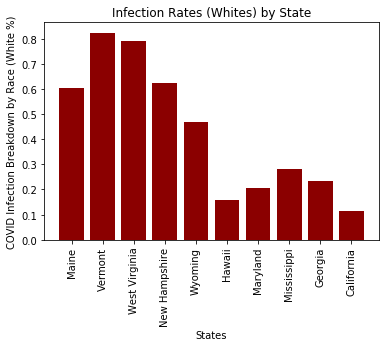

<Figure size 720x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [26]:
#Infection broken down by minorities

#Determine % of infections that are minority
racial_breakdown_df["minority_infection_rate"] = racial_breakdown_df["minority_group_infections"] / racial_breakdown_df["Cases_Total"]
racial_breakdown_df["white_infection_rate"] = racial_breakdown_df["Cases_White"] / racial_breakdown_df["Cases_Total"]

infection_breakdown_bar = racial_breakdown_df[["State", "minority_infection_rate", "white_infection_rate"]]
states = infection_breakdown_bar["State"]
infection_breakdown_bar = infection_breakdown_bar.set_index(states)

#Plot chart using madplotlib
A = infection_breakdown_bar["white_infection_rate"]

X = infection_breakdown_bar["State"]

plt.bar(X, A, color = 'darkred')
#plt.bar(X, B, color = 'lightcoral', bottom = A)

#Chart formatting
plt.xticks(rotation='vertical')
plt.xlabel("States")
plt.ylabel("COVID Infection Breakdown by Race (White %)")
plt.title("Infection Rates (Whites) by State")
plt.figure(figsize=(10,7))
plt.tight_layout()

#Show and save chart
plt.show()
plt.savefig("Charts/White_Infection_Rate_by_State.png")

In [ ]:
#Scatter Plot: Infection Rates by % of Minority - matplotlib

infections = covid_breakdown_bar["Percentage Infected"]
demographics = racial_breakdown_df["minority_groups"]

# Without scoop_price
plt.scatter(infections, demographics, marker="o", facecolors="lightcoral", edgecolors="black")

# Chart Formatting
plt.xlim(0,.015)
plt.title("COVID-19 Infection Rate vs. % of Population - Minorities")
plt.xlabel("COVID-19 Infection Rate")
plt.ylabel("% of Population - Minorities")

plt.savefig("Charts/Infection_Rate_vs_Minorities.png")

In [ ]:
#Scatter Plot: Infection Rates by % of Whites - matplotlib

deaths = racial_breakdown_df["Death Percentage"]
demographics = racial_breakdown_df["minority_groups"]

# Without scoop_price
plt.scatter(deaths, demographics, marker="o", facecolors="salmon", edgecolors="black", alpha=0.8)

# Chart Formatting
plt.xlim(0,.00065)
plt.title("COVID-19 Death Rate vs. % of Population - Minorities")
plt.xlabel("COVID-19 Death Rate")
plt.ylabel("% of Population - Minorities")

plt.savefig("Charts/Death_Rate_vs_Minorities.png")